# *Group 39*: **Project Final Report**

In [1]:
# Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction:

Understanding the factors that influence how much time the player spends in a game is an important part of game design and player behavior research. Play time is often regarded as a measure of player engagement, learning progression, and overall satisfaction with the game. For Minecraft players, their characteristics, such as ages and previous gaming experience, will significantly shape how long individuals play and how quickly they learn game mechanics.

In this project, we try to answer the following research question:
Can a player's age and experience level be used to predict their total play time (played_hours)?
By analyzing the relationship between these variables, we hope to better understand which types of players tend to play for longer periods and whether experience level becomes a reliable indicator of engagement.

To investigate this question, we used the players.csv dataset, which contains information on 196 Minecraft players and seven variables: experience, subscribe, hashedEmail, name, gender, played_hours, and Age.
For our analysis, we chose the key variables that related to prediction: Experience, Age, and played_hours. The experience column contains five categories (Beginner, Regular, Amateur, Veteran, Pro), which we transfer into ordered numerical values to support statistical modeling. In the data-cleaning process, we identified and removed the missing values to ensure accurate analysis.
## Variables in players.csv

| Variable Name | Type        | Description |
|---------------|-------------|-------------|
| **experience** | Categorical | The player's experience level in the game (Beginner, Regular, Amateur, Veteran, Pro). |
| **subscribe**  | Logical     | Whether the player subscribed to the Minecraft-related newsletter. |
| **hashedEmail**| Feature     | A unique hashed identifier for each player. |
| **played_hours** | Numeric  | Total hours the player has spent playing the game. |
| **name**        | Feature    | The in-game avatar name of the player. |
| **gender**      | Feature    | The player’s reported gender. |
| **Age**         | Numeric    | The player’s age. |


Based on our work with the cleaned dataset and exploring patterns, ages, and total play time, we have laid the groundwork for subsequent use of methods such as K-Nearest Neighbor(KNN) regression to evaluate whether these features can effectively predict game duration. All the variables needed for this analysis are available in the players dataset hence why we only need to use the players dataset.

In [2]:
players_url <- "https://raw.githubusercontent.com/iSqlqmi/dsci_100_group_project/refs/heads/main/data/players.csv"

players <- read_csv(players_url)
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


# Methods and Results:

**Proposed Method**: Using knn regression to predict the played_hours for each player given the data from the experience and age columns

Next, we need to wrangle our data. Since `experience`, `played_hours`, and `Age`, are the only required columns for the analysis, we begin by selecting the required columns and ignoring the rest of the columns.

In [3]:
players_select <- players |> select(experience,played_hours,Age)
players_select

experience,played_hours,Age
<chr>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
⋮,⋮,⋮
Amateur,0.0,57
Amateur,2.3,17
Pro,0.2,NA


The next step of wrangling, involves converting the experience column from character column into a numerical column since knn regression requires all predictors to be numerical. This begins by first identifying all the unique experience levels in `experience` column and ensure that there no **NA** rows.

In [4]:
unique(players_select$experience)
any(is.na(players_select$experience))

[1] "Pro"      "Veteran"  "Amateur"  "Regular"  "Beginner"

[1] FALSE

There are 5 experience levels in `experience` column and all rows contain an experience level: Pro, Veteran, Amateur, Regular and Beginner. A few searches in gaming forums show the order of these ranks: Beginner < Regular < Amateur < Veteran < Pro  
We can use this information and assign a unique numerical value for each rank.  
`Beginner` = 1  
`Regular`  = 2  
`Amateur`  = 3  
`Veteran`  = 4  
`Pro`      = 5

In [5]:
players_mutate <- players_select |>
            mutate(experience_num = case_when(
                experience == "Beginner" ~ 1,
                experience == "Regular" ~ 2,
                experience == "Amateur" ~ 3,
                experience == "Veteran" ~ 4,
                experience == "Pro" ~ 5))
players_mutate

experience,played_hours,Age,experience_num
<chr>,<dbl>,<dbl>,<dbl>
Pro,30.3,9,5
Veteran,3.8,17,4
Veteran,0.0,17,4
⋮,⋮,⋮,⋮
Amateur,0.0,57,3
Amateur,2.3,17,3
Pro,0.2,NA,5


With all the experience levels converted into numerical value and added to a new column, `experience` can be dropped from our dataframe.

In [6]:
players_mutate <- players_mutate |> select(-experience)
players_mutate

played_hours,Age,experience_num
<dbl>,<dbl>,<dbl>
30.3,9,5
3.8,17,4
0.0,17,4
⋮,⋮,⋮
0.0,57,3
2.3,17,3
0.2,NA,5


After successfully wrangling the data, we can perfom a summary of all the relevant columns that are relavant to our data analysis and add the mean values to a dataframe.

In [7]:
summary(players_mutate)

players_mean_table <- players_mutate |> summarize(play_hours_mean = round(mean(played_hours), 2), 
                                                  age_mean = round(mean(Age,na.rm= TRUE), 2), 
                                                  experience_mean = round(mean(experience_num),2))
players_mean_table

  played_hours          Age        experience_num 
 Min.   :  0.000   Min.   : 9.00   Min.   :1.000  
 1st Qu.:  0.000   1st Qu.:17.00   1st Qu.:2.000  
 Median :  0.100   Median :19.00   Median :3.000  
 Mean   :  5.846   Mean   :21.14   Mean   :2.847  
 3rd Qu.:  0.600   3rd Qu.:22.75   3rd Qu.:4.000  
 Max.   :223.100   Max.   :58.00   Max.   :5.000  
                   NA's   :2                      

play_hours_mean,age_mean,experience_mean
<dbl>,<dbl>,<dbl>
5.85,21.14,2.85


Next we proceeded by analyzing the relationship between the predictors `experience`, `Age`, and response valraible `played_hours`.

We begin by looking at the relationship between `played_hours` and `Age`. (For this example, we use the players dataframe since our experience column is character making it easier to differentiate between each experience rank)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


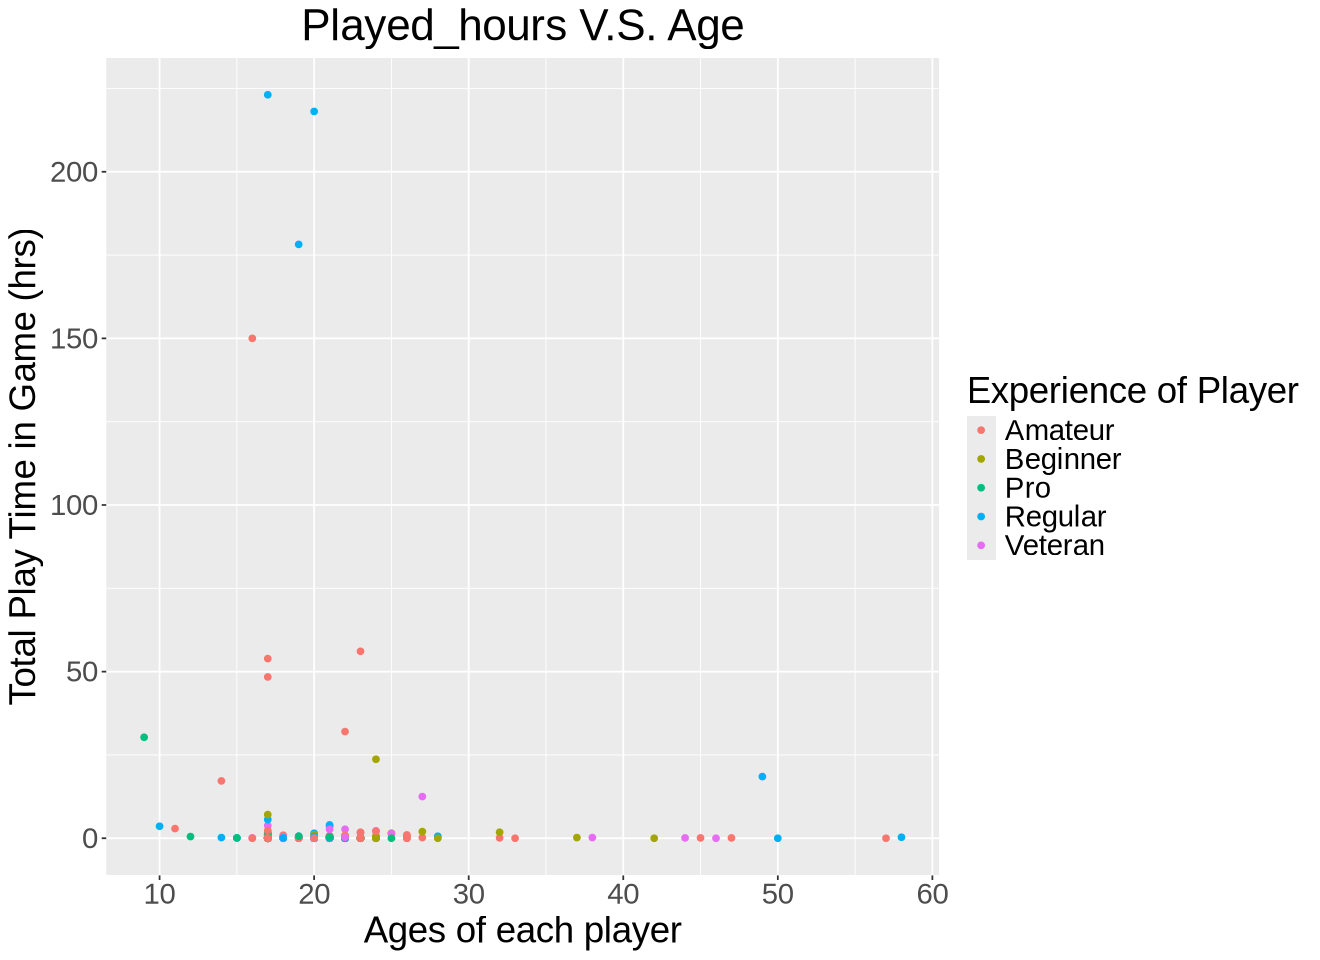

In [8]:
options(repr.plot.width = 11, repr.plot.height = 8)
hours_experience_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = experience)) +
    geom_point() +
    labs(
        x = "Ages of each player",
        y = "Total Play Time in Game (hrs)",
        color = "Experience of Player",
        title = "Played_hours V.S. Age") +
    theme(text = element_text(size = 22),
         plot.title = element_text(hjust = 0.5))
hours_experience_plot

Next we look at the Average played hours between each experience rank. This involves by grouping all the `experience` rows together and find the average played between them.

experience,avg_played_hours
<fct>,<dbl>
Veteran,0.6479167
Beginner,1.2485714
Pro,2.6000000
Amateur,6.0174603
Regular,18.2083333


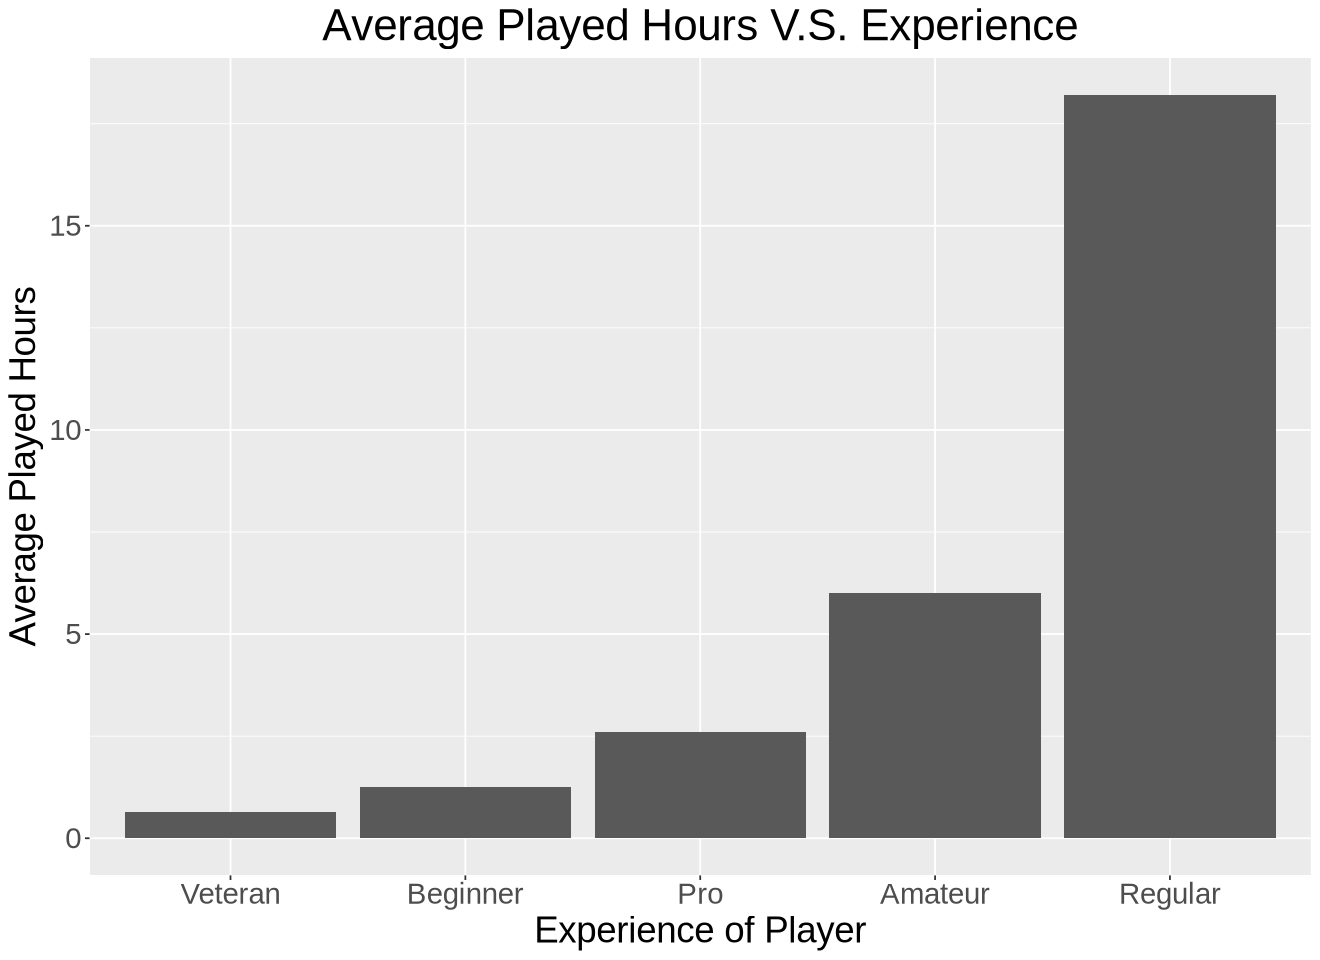

In [9]:
avg_played_hours <- players_mutate |> select(experience_num, played_hours) |> group_by(experience_num) |>
                    summarize(avg_played_hours = mean(played_hours)) |>
                    mutate(experience = case_when(
                experience_num == 1 ~ "Beginner",
                experience_num == 2 ~ "Regular",
                experience_num == 3 ~ "Amateur",
                experience_num == 4 ~ "Veteran",
                experience_num == 5 ~ "Pro")) |>
                relocate(experience) |> select(-experience_num) |> arrange(avg_played_hours) |>
                mutate(experience = fct_inorder(experience)) #Function used to allow R to plot from top to bottom (sorted)
                                                             #instead of alphabetic order
avg_played_hours

avg_hours_exp_plot <- avg_played_hours |>
                        ggplot(aes(x = experience, y = avg_played_hours))+
                        geom_bar(stat = "identity") +
                        labs(
                            x = "Experience of Player",
                            y = "Average Played Hours",
                            title = "Average Played Hours V.S. Experience") +
                        theme(text = element_text(size = 22),
                             plot.title = element_text(hjust = 0.5))
avg_hours_exp_plot

**Insights from the plots:** From the scatter plot, people in the ages 15-25 have more play time then the other groups which could mean that they have more time/bigger interest playing games. From the bar graph, people in the regular experience groups had highest avergae play time followed by amateur experience groups which could be because it can take newer players more time to get used to the game mechanics and regular players are more casual with their play style compared to veteran players who already know how to play really well and know all of the mechnanics. One disadvantage could be that Veteran, Beginner and Pro players are underrepresented which may impact the predictions.

# *Data Analysis:*

For our data analysis we will be using KNN regressions to predict the played_hours for each player given the data from the experience and age columns from the players dataset. I chose to use the model regression because the value I am predicting (played_hours) is not a categorical variable so we can't use classification since classification predicts on a categorical variable. 

To perform the prediction we will first split the dataset (players_mutate since this dataset has the experience column converted into numerical values) into 75% training and 25% testing sets named players_split, players_train, and players_test respectively.

In [10]:
set.seed(1)

players_mutate_2 <- players_mutate |>
    drop_na()

players_split <- initial_split(players_mutate_2, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

players_mutate_2

played_hours,Age,experience_num
<dbl>,<dbl>,<dbl>
30.3,9,5
3.8,17,4
0.0,17,4
⋮,⋮,⋮
0.3,22,4
0.0,57,3
2.3,17,3


Now we will use R to perform cross-validation and to choose the optimal K. First, we will create a recipe for preprocessing our data and include standardization for our two explanatory variables `age` and `experience` calling it players_recipe. Next we create a model specification for K-nearest neighbors regression rembering to do `neighbors = tune()` and using "regression" in the `set_mode` function calling it players_spec. Then we create a 5-fold cross-validation object calling it players_vfold, and put the recipe and model specification together in a workflow called players_wkflow.

In [11]:
players_recipe <- recipe(played_hours ~., data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

players_wkflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)
players_wkflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next we run cross-validation for a grid of numbers of neighbors ranging from 1 to 30. The following code tunes the model and returns the RMSPE for each number of neighbors. In the output of the players_results results data frame, we see that the neighbors variable contains the value of K, the mean contains the value of the RMSPE estimated via cross-validation, and the standard error (std_err) contains a value corresponding to a measure of how uncertain we are in the mean value.

In [12]:
gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

players_results <- players_wkflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

# show the results
players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,32.86603,5,7.893326,Preprocessor1_Model01
2,rmse,standard,35.50055,5,4.991465,Preprocessor1_Model02
3,rmse,standard,35.36425,5,5.402963,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,rmse,standard,30.00154,5,6.502720,Preprocessor1_Model28
29,rmse,standard,29.88523,5,6.544938,Preprocessor1_Model29
30,rmse,standard,29.94073,5,6.578529,Preprocessor1_Model30


Lets see a visualization of the K values indictated by the range of 1 to 30 below

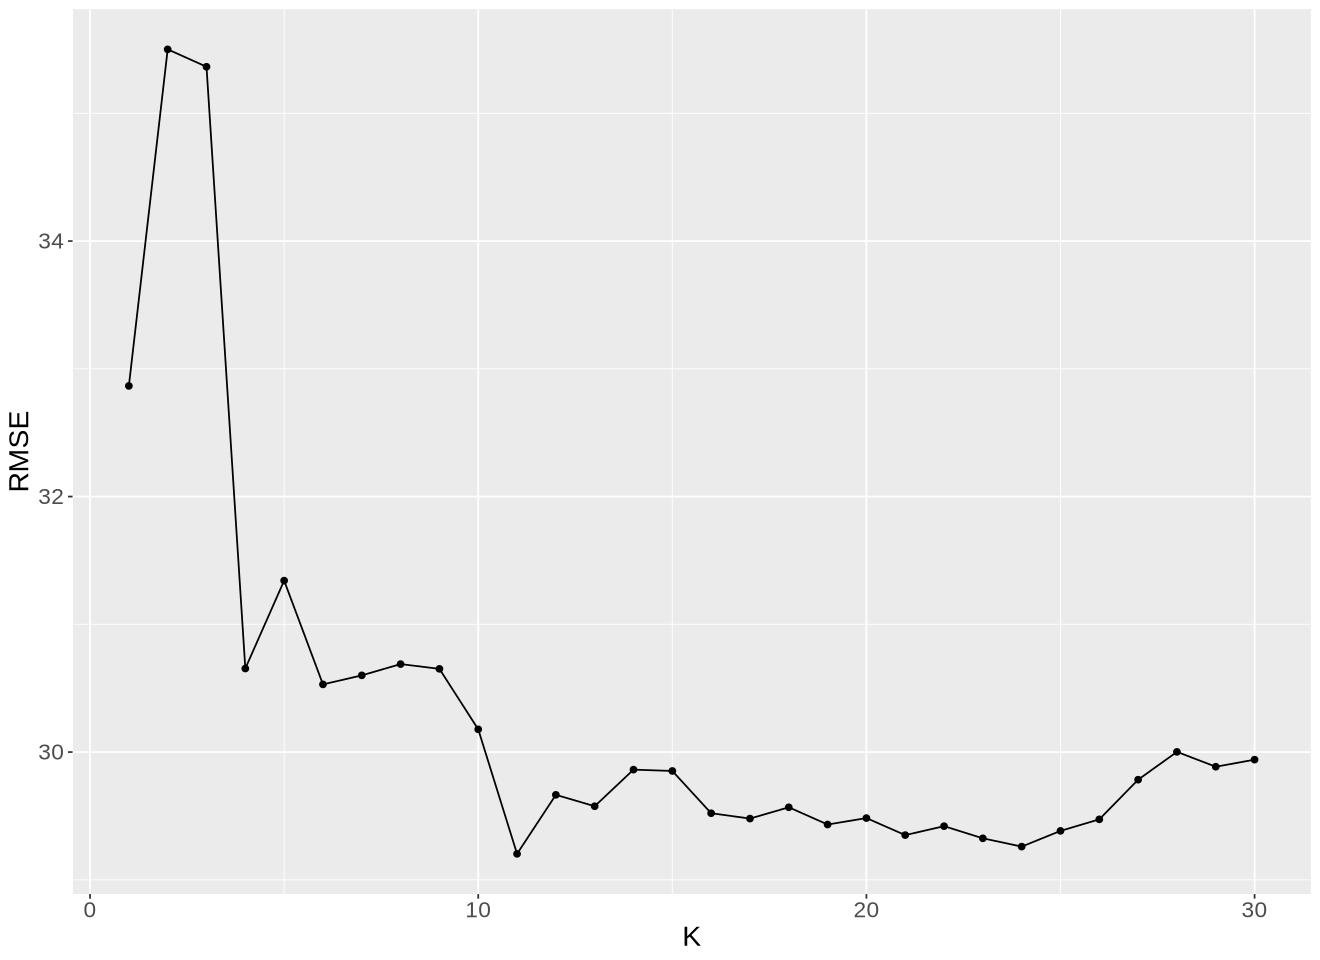

In [13]:
k_values_plot <- players_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(
        x = "K",
        y = "RMSE") +
    theme(text = element_text(size = 17))
k_values_plot

We can clearly see a dip between 10 to 15 so we find the min of the means below to find our best K value

In [14]:
best_k <- players_results |>
    filter(mean == min(mean)) |>
    pull(neighbors)

# show the results
best_k

[1] 11

Let’s continue the analysis to see how we can make predictions with a multivariable K-NN regression model and evaluate its performance on test data. We first need to re-train the model on the entire training data set with K = 11, and then use that model to make predictions on the test data.

In [15]:
players_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("regression")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec_2) |>
  fit(data = players_test)

players_preds <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test)

players_summary <- metrics(players_preds, truth = played_hours, estimate = .pred) |>
                     filter(.metric == 'rmse')

players_summary
players_preds

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.31946


.pred,played_hours,Age,experience_num
<dbl>,<dbl>,<dbl>,<dbl>
0.4090909,0,17,3
1.1272727,0,19,2
0.6181818,0,21,3
⋮,⋮,⋮,⋮
0.4090909,0.0,20,3
0.3090909,0.3,22,4
0.4272727,0.0,57,3


Lastly, lets create two visualizations with our predicted values one for comparing Age with played_hours and one with experience and played_hours.

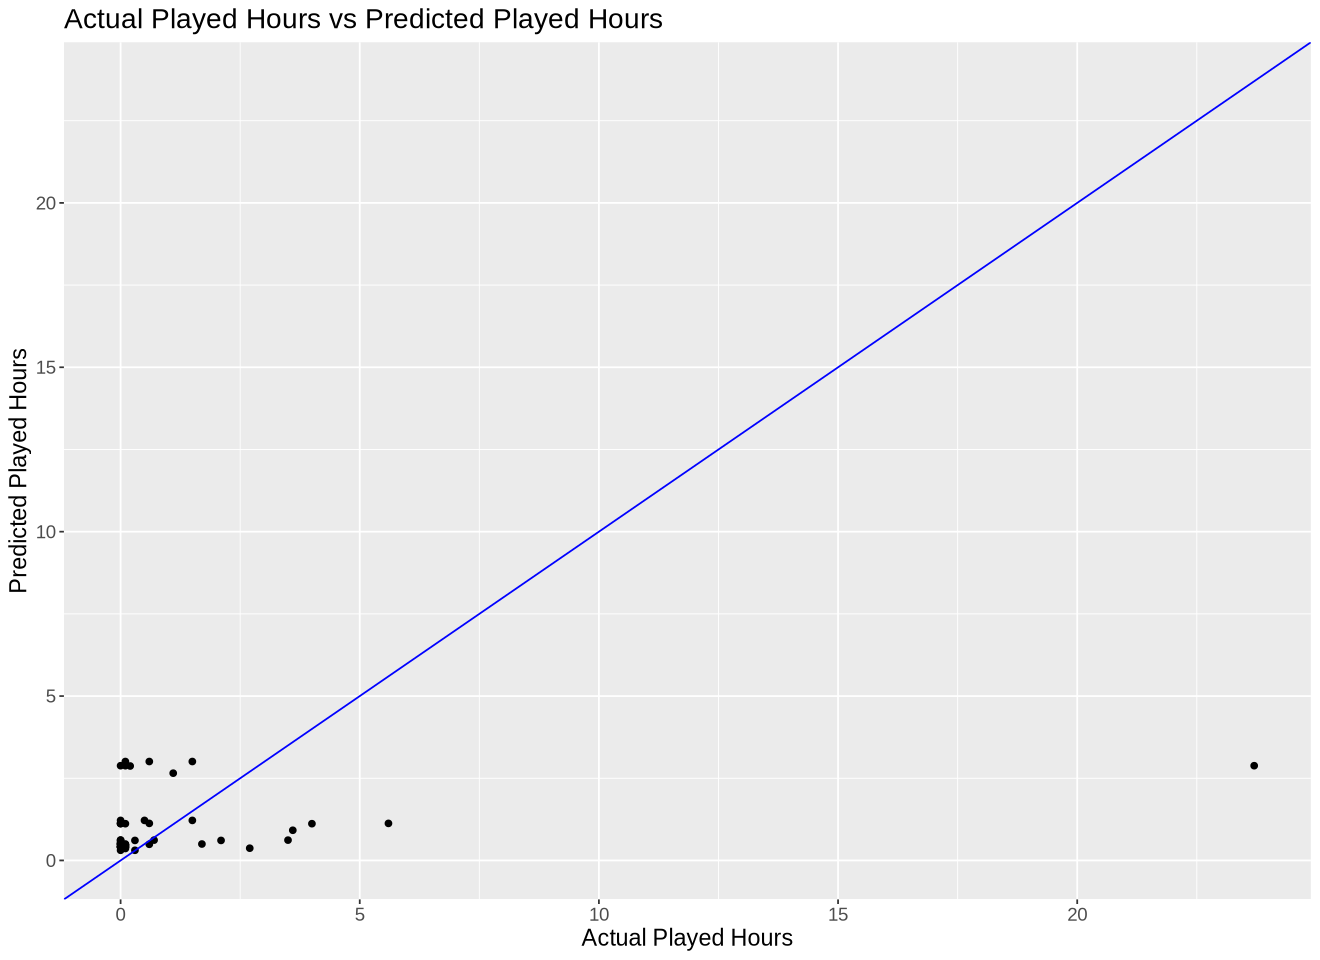

In [16]:
# breifly explain why we are using qqplot

max_val <- max(players_preds$played_hours, na.rm = TRUE)

age_plot_3 <- ggplot(players_preds, aes(x = played_hours, y = .pred)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, color = "blue") +
  coord_cartesian(xlim = c(0, max_val), ylim = c(0, max_val)) +
  labs(
      x = "Actual Played Hours",
      y = "Predicted Played Hours",
      title = "Actual Played Hours vs Predicted Played Hours") +
  theme(text = element_text(size = 14))
age_plot_3

# add point 0,0 and 1,1 then make geom line equal to y = x
#Make qq plot for actual played_hours compared to predicted played_hours and then see if we have to filter based off of Age

experience_num,played_hours,.pred
<chr>,<dbl>,<dbl>
Beginner,3.4125000,2.9000000
Regular,1.4454545,1.1305785
Amateur,0.4928571,0.4987013
Veteran,0.3090909,0.4371901
Pro,0.4800000,0.4981818


No summary function supplied, defaulting to `mean_se()`


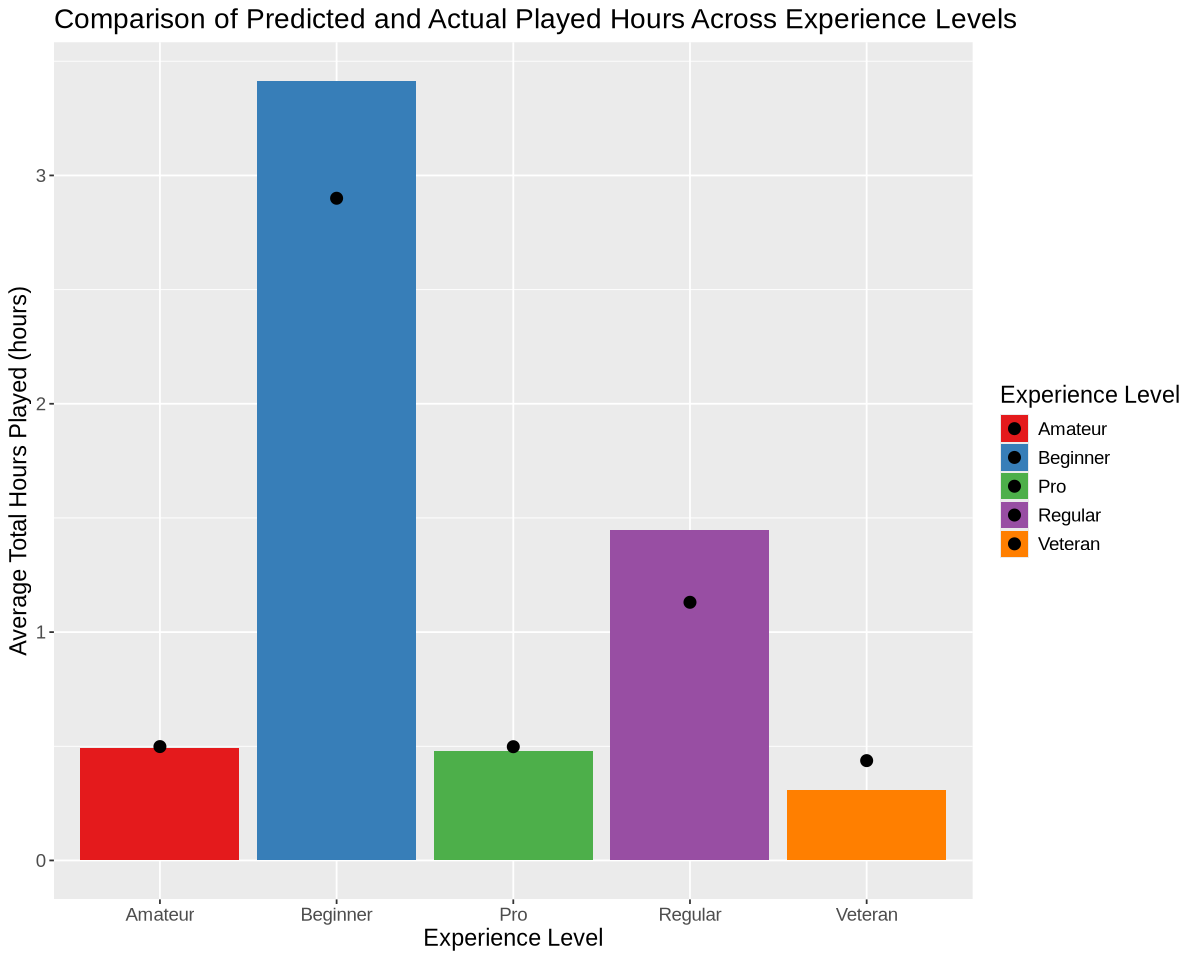

In [17]:
exp_preds_2 <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    group_by(experience_num) |>
     summarize(played_hours = mean(played_hours),
              .pred = mean(.pred)) |>
   mutate(experience_num = case_when(
                experience_num == 1 ~ "Beginner",
                experience_num == 2 ~ "Regular",
                experience_num == 3 ~ "Amateur",
                experience_num == 4 ~ "Veteran",
                experience_num == 5 ~ "Pro"))
exp_preds_2

options(repr.plot.width = 10, repr.plot.height = 8)

exp_prediction_plot_2 <- ggplot(exp_preds_2, aes(x = experience_num, y = played_hours, fill = experience_num)) +
    geom_bar(stat = "summary") +
    geom_point(aes(y = .pred), size = 3) +

    labs(title = "Comparison of Predicted and Actual Played Hours Across Experience Levels",
         x = "Experience Level", 
         y = "Average Total Hours Played (hours)",
        fill = "Experience Level") +
    scale_fill_brewer(palette = "Set1") +
    theme(text = element_text(size = 14))
    
exp_prediction_plot_2

# Discussion:

The results visualized above demonstrate that there is a strong correlation between player's experience level and hours played and a weak correlation between player's age and hours played. First, looking at the correlation between player's age and hours played, shows that Players' age is not a good predictor for predicting the hours played. This could be due to the fact that there is not a set amount of hours played for any age group, meaning a child could play 10 minutes or it could play 4 hours. The same can also be said about adults. On the other side, players that fall within the "regular" and "amateur" category are more likely to spend higher amounts of time than complete beginners and more advanced players.
Our model was able to accurately predict amateur and pro levels while under-predicted beginner and regular played hours. The model also over predicted veteran played hours. One error may have been a data pool too small for the model to accurately predict all of the potential experience levels besides pro and amateur. Another issue could be that since the sample pool for pro players is small as seen from the data analysis, the prediction accuracy may not be reliable, meaning there is not enough data to say for certain that pro categories prediction accuracy is on point. 

People with are familiar with the game but still new will spend the most time playing the game. This could suggest that complete beginners find the game difficult to understand and hard to pick up and therefore play less hours. On the other hand, players with much more experience may find the game too easy and are no longer interested in continuing to play. Based on these inferences, developers of this experience should focus on creating ways for beginners to understand and work through the game. Maybe suggesting a tutorial video or writing a guidebook to the game would encourage these players to invest more time into Minecraft. On the other side, developers could add new challenges and tasks for veteran players to attempt in order to keep longer engagement of an audience who may find the server uninteresting.

Many future questions that can be derived from our research revolve around player retention. Questions like "will adding a tutorial lead to more beginner-level player retention" or "can more structured or achievement based gameplay lead to longer player retention" are interesting questions that can be researched further. Taking a step back, researchers can ask questions about other variables and their impact on player retention such as "does playing with others impact hours played" or "how do differing schedules affect hours played".

# References: